# Model Evaluation & Optimization

In [1]:
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from scipy.stats import ttest_rel, probplot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils.comprehensive_evaluation import comprehensive_evaluation

X_train = pd.read_csv("../data/processed/X_train.csv")
y_train = pd.read_csv("../data/processed/y_train.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

target_variable = "volume_per_ha"

# Initialize two models - linear regression and extra trees - selected them because they performed best in the last two notebooks
models = {
    "Linear": LinearRegression(),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=100, max_depth=20, random_state=42),
}
for name, model in models.items():
    model.fit(X_train, y_train[target_variable])

    score = cross_val_score(model, X_train, y_train[target_variable], cv=5).mean()
    print(f"{name}: {score:.3f}")

Linear: 0.880
ExtraTrees: 0.994


## Bootstrap Confidence Intervals

Bootstrap resampling provides confidence intervals for your performance metrics without making distributional assumptions. By repeatedly resampling your data and recalculating metrics, you can estimate the uncertainty in your performance measurements. This uncertainty quantification helps communicate model reliability to stakeholders.

**Bootstrap Process:**

1. **Resample:** Create new datasets by sampling with replacement.
2. **Retrain:** Fit model on each bootstrap sample.
3. **Evaluate:** Calculate performance on original test set.
4. **Aggregate:** Compute confidence intervals from bootstrap distribution.

**Business Value:**

- **Uncertainty communication:** "R² is 0.82 ± 0.05 with 95% confidence".
- **Risk assessment:** Understand potential performance variation.
- **Model comparison:** Determine if performance differences are significant.

In [2]:
bootstrap_scores = []
for i in range(100):
    # Bootstrap sample
    X_boot, y_boot = resample(X_train, y_train[target_variable], random_state=i)
    models["ExtraTrees"].fit(X_boot, y_boot)
    score = models["ExtraTrees"].score(X_test, y_test)
    bootstrap_scores.append(score)

# Confidence interval
ci_lower = np.percentile(bootstrap_scores, 2.5)
ci_upper = np.percentile(bootstrap_scores, 97.5)
print(f"R² 95% Confidence Interval: [{ci_lower:.3f}, {ci_upper:.3f}]")

R² 95% Confidence Interval: [0.993, 0.995]


# Comparing Multiple Models Statistically

When comparing model performance, random variation can make inferior models appear better on specific test sets. Statistical tests help determine whether observed performance differences are meaningful or just random noise. This prevents poor model selection decisions based on statistical flukes.

**Statistical Comparison Approaches:**

- **Paired t-test:** Compare models on same CV folds.
- **Wilcoxon signed-rank:** Non-parametric alternative to t-test.
- **McNemar's test:** For classification model comparison.
- **Bootstrap hypothesis testing:** Resample-based significance testing.

**Significance Interpretation:**

- **p < 0.05:** Strong evidence of real performance difference.
- **p > 0.05:** Insufficient evidence of difference (prefer simpler model).
- **Effect size:** Consider practical significance alongside statistical significance.

In [3]:
# Compare two models using CV
model1_scores = cross_val_score(
    models["ExtraTrees"], X_test, y_test[target_variable], cv=5
)
model2_scores = cross_val_score(models["Linear"], X_test, y_test[target_variable], cv=5)

# Paired t-test
t_stat, p_value = ttest_rel(model1_scores, model2_scores)
print(f"Model comparison p-value: {p_value:.3f}")
if p_value < 0.05:
    print("Significant performance difference detected")
else:
    print("No significant difference - choose simpler model")

Model comparison p-value: 0.016
Significant performance difference detected


## Residual Analysis and Diagnostic Plots

Residuals (prediction errors) are like x-rays for your model because they reveal hidden problems that summary statistics might miss. Systematic patterns in residuals indicate assumption violations, missing features, or inappropriate model choices. Good residual analysis prevents deploying fundamentally flawed models.

**Key Diagnostic Plots:**

- **Residuals vs. Fitted:** Check for non-linear patterns and heteroscedasticity.
- **Q-Q Plot:** Assess normality of residuals.
- **Scale-Location:** Detect changing variance (heteroscedasticity).
- **Residuals vs. Features:** Identify relationships missed by model.

**What Patterns Reveal:**

- **Random scatter:** Model assumptions satisfied.
- **Curved patterns:** Non-linear relationships exist.
- **Funnel shape:** Variance increases with prediction level.
- **Extreme outliers:** Data quality issues or model limitations.

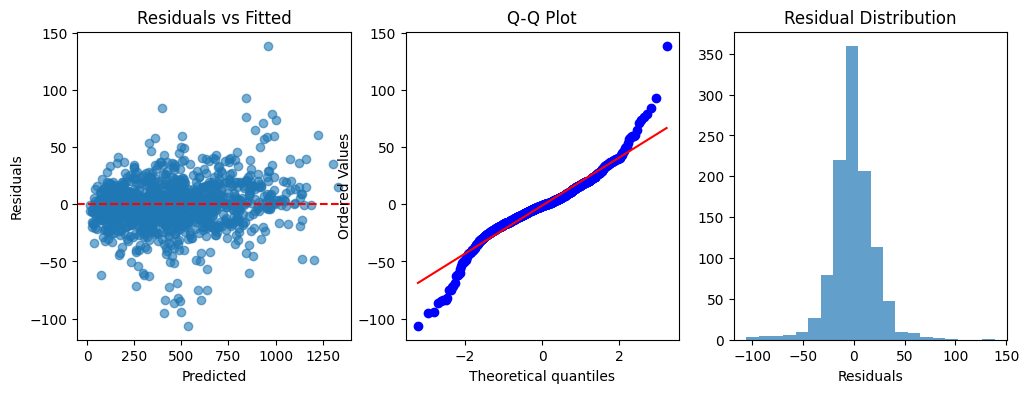

In [4]:
y_pred = models["ExtraTrees"].predict(X_test)
residuals = y_test[target_variable] - y_pred

# Residuals vs fitted plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")

# Q-Q plot
plt.subplot(1, 3, 2)
probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")

# Histogram
plt.subplot(1, 3, 3)
plt.hist(residuals, bins=20, alpha=0.7)
plt.xlabel("Residuals")
plt.title("Residual Distribution")
plt.show()

## Prediction vs. Actual Visualization

The prediction vs. actual scatter plot is your model's report card in visual form. Perfect predictions would line up exactly on the diagonal and deviations reveal where and how your model struggles. This plot immediately communicates model quality to both technical and non-technical stakeholders.

**Plot Interpretation:**

- **Points on diagonal:** Perfect predictions.
- **Scattered around diagonal:** Good model with typical errors.
- **Systematic deviations:** Model bias in certain ranges.
- **Heteroscedasticity:** Error magnitude changes with prediction level.

**Advanced Analysis:**

- **Color by features:** Identify which inputs correlate with errors.
- **Confidence bands:** Show prediction uncertainty.
- **Residual magnitude:** Size points by absolute error.
- **Outlier identification:** Highlight extreme prediction errors.

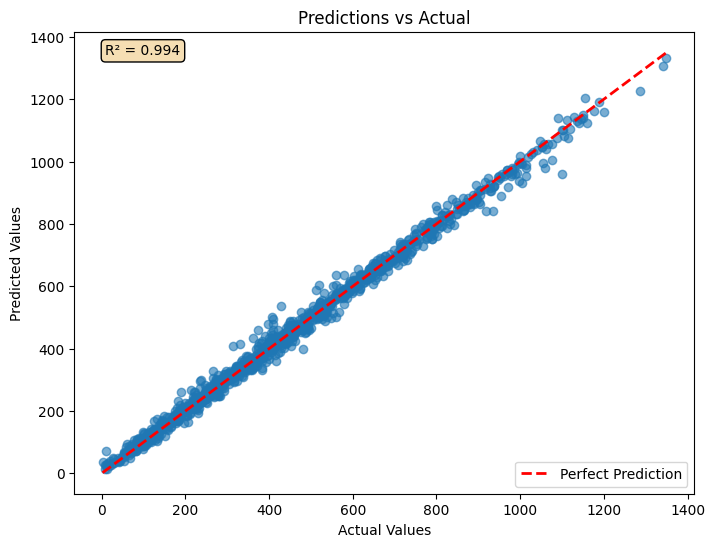

In [5]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--",
    lw=2,
    label="Perfect Prediction",
)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predictions vs Actual")
plt.legend()

# Add R² to plot
r2 = r2_score(y_test, y_pred)
plt.text(
    0.05,
    0.95,
    f"R² = {r2:.3f}",
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round", facecolor="wheat"),
)
plt.show()

## Feature Importance and Model Interpretability

Understanding which features drive your predictions is often as valuable as the predictions themselves. Feature importance helps prioritize data collection, guide business decisions, and build stakeholder trust. Different models provide importance through different mechanisms. For example, linear models use coefficient magnitudes, while tree-based models use split criteria.

**Importance Calculation Methods:**

- **Coefficient magnitude:** For linear models (requires feature scaling).
- **Permutation importance:** Model-agnostic approach.
- **Drop-one analysis:** Performance decrease when feature removed.
- **SHAP values:** Game theory-based feature attribution.

**Business Applications:**

- **Resource allocation:** Focus on high-impact measurements.
- **Process improvement:** Target influential operational factors.
- **Data strategy:** Prioritize collection of important features.

In [6]:
coef_importance = pd.DataFrame(
    {
        "feature": X_test.columns,
        "importance": abs(models["ExtraTrees"].feature_importances_),
    }
).sort_values("importance", ascending=False)

print("Top 5 features (coef):", coef_importance.head())

perm_importance = permutation_importance(
    models["ExtraTrees"], X_test, y_test, n_repeats=10
)
perm_df = pd.DataFrame(
    {"feature": X_test.columns, "importance": perm_importance.importances_mean}
).sort_values("importance", ascending=False)

print("Top 5 features (permutation_importance):", perm_df.head())

Top 5 features (coef):           feature  importance
3  average_height    0.651659
4             dbh    0.161452
6    trees_per_ha    0.059660
0              id    0.043686
2             age    0.034351
Top 5 features (permutation_importance):           feature  importance
3  average_height    1.279793
6    trees_per_ha    0.104395
4             dbh    0.084047
0              id    0.046762
1     yield_class    0.026082


In [11]:
comprehensive_evaluation(
    models["Linear"], X_train, X_test, y_train[target_variable], y_test[target_variable]
)

print("\n" * 4)

comprehensive_evaluation(
    models["ExtraTrees"],
    X_train,
    X_test,
    y_train[target_variable],
    y_test[target_variable],
)

=== MODEL EVALUATION REPORT ===
Model Type: LinearRegression
Training Samples: 3314
Test Samples: 1105

Performance Metrics:
  R²: 0.856
  RMSE: 103.833
  MAE: 71.981
  MAPE: 36.840
  CV R²: 0.880 ± 0.006

Model Diagnostics:
  Residual mean: 1.709488
  Residual std: 103.866
✅ RECOMMENDATION: Model ready for deployment





=== MODEL EVALUATION REPORT ===
Model Type: ExtraTreesRegressor
Training Samples: 3314
Test Samples: 1105

Performance Metrics:
  R²: 0.996
  RMSE: 17.664
  MAE: 12.031
  MAPE: 6.324
  CV R²: 0.994 ± 0.000

Model Diagnostics:
  Residual mean: -0.808323
  Residual std: 17.654
✅ RECOMMENDATION: Model ready for deployment


{'R²': 0.9958419730171836,
 'RMSE': 17.664486426576197,
 'MAE': 12.031180259381493,
 'MAPE': np.float64(6.323725700250255)}